[View in Colaboratory](https://colab.research.google.com/github/DongminWu/MLpractice/blob/master/seq2seq_autoencoder.ipynb)

# Seq2seq testing

The main purpose is to try about the Seq2Seq LSTM neural network, to see if it can be used for feature extraction of time series data.

The structure and explaination of Seq2Seq neural network is [here](https://guillaumegenthial.github.io/sequence-to-sequence.html)

In this notebook, I will just try the vanilla Seq2Seq with some atificial data.


## Structure of 'this' Vanilla Seq2Seq 


- Input Data: Time series, binary data. The density of the data varies amongst time.
- Goal: Makeing the Neural Network learn the hidden pattern inside the time series, by using the values of the latent layer(extracted features), we can easily clustering the data.



# Libraries

In [0]:

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from scipy.stats import norm

from scipy.signal import triang

# Faking some data

1. Gaussian distributions, different mean and different variance
2. Triangle waves, with different sequence

All the data will contain 10% of random probabilities.

## Probability density funcitons

In [0]:
day_length = 1440

In [0]:
def gaussian_pdf(mu,  sigma, length):
  '''
  mu: mean of the gaussian distribution
  sigma: variance of the gaussian distribution
  
  length: the length of the sequence
  '''
  
  raw_ = np.linspace(-5, 5, length)
  ret = 1/(sigma * np.sqrt(2 * np.pi)) * \
      np.exp( - (raw_ - mu)**2 / (2 * sigma**2))
  return ret
                     

143.8999189797876

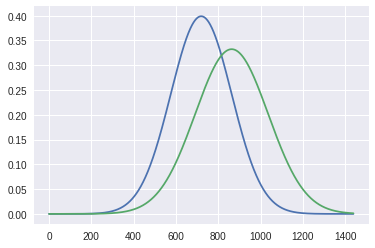

In [123]:
g1 = gaussian_pdf(0, 1, day_length)
g2 = gaussian_pdf(1, 1.2, day_length)

plt.plot(g1)
plt.plot(g2)


g1.sum()

288.0

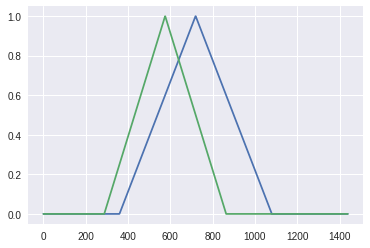

In [124]:
# Triangle wave

def triangle_pdf(mid, width, length):

  raw_ = np.linspace(-5, 5, length)

  l_mask = mid  - float(width)/2
  l_empty = np.where(raw_ < l_mask)[0]

  ret_l = [0]*len(l_empty)

  r_mask = mid + float(width)/2
  r_empty = np.where(raw_ > r_mask)[0]
  ret_r = [0]*len(r_empty)

  number_mid = length - len(l_empty) - len(r_empty)
  ret_m = triang(number_mid)

  ret = np.concatenate([ret_l, ret_m, ret_r])
  
#   h = 2. / width
  
  ret = ret
  
  return ret

t1 = triangle_pdf(0,5, day_length)
t2 = triangle_pdf(-1,4, day_length)



plt.plot(t1)
plt.plot(t2)


t2.sum()

In [0]:
# def rectangle_pdf()

In [0]:
def random_pdf(prob, max, length):
  raw = [0] * length
  
  for i,each in enumerate(raw):
    r = np.random.random()
    if r < prob:
      raw[i] = np.random.uniform(-max, max)

  return np.array(raw)

r1 = random_pdf(0.1, 0.2, day_length)


In [0]:
def generate_binary(distribution):
  return np.array([np.random.choice( np.array([0,1]),p=[1-p,p]) for p in distribution])

## Generating fake data 

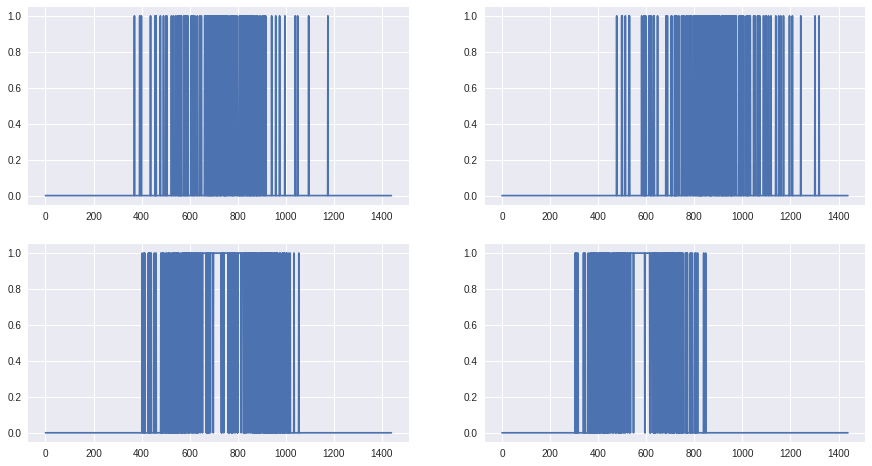

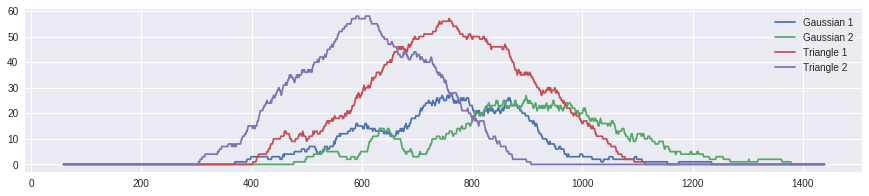

In [128]:

gr1 = np.clip(g1 + r1, 0, 1)
gr2 = np.clip(g2 + r1, 0, 1)
tr1 = np.clip(t1 + r1, 0, 1)
tr2 = np.clip(t2 + r1, 0, 1)

gr1 = g1
gr2 = g2
tr1 = t1
tr2 = t2




d_g1 = [np.random.choice( np.array([0,1]),p=[1-p,p]) for p in gr1]
d_g2 = [np.random.choice( np.array([0,1]),p=[1-p,p]) for p in gr2]
d_t1 = [np.random.choice( np.array([0,1]),p=[1-p,p]) for p in tr1]
d_t2 = [np.random.choice( np.array([0,1]),p=[1-p,p]) for p in tr2]


plt.figure(figsize=(15,8))


plt.subplot(2,2,1)
plt.plot(d_g1)

plt.subplot(2,2,2)
plt.plot(d_g2)

plt.subplot(2,2,3)
plt.plot(d_t1)

plt.subplot(2,2,4)
plt.plot(d_t2)

plt.show()


data_sample = pd.DataFrame()

data_sample['Gaussian 1'] = d_g1
data_sample['Gaussian 2'] = d_g2


data_sample['Triangle 1'] = d_t1
data_sample['Triangle 2'] = d_t2


data_sample.rolling(60).sum() \
        .plot(figsize=(15,3))


In [129]:
num_of_each_type = 18
num_of_weekend = 13

# 4 sensors

g1_set = [generate_binary(gaussian_pdf(0,1,day_length)) for i in range(num_of_each_type)]
g2_set = [generate_binary(gaussian_pdf(1,1.3,day_length)) for i in range(num_of_each_type)]
t1_set = [generate_binary(triangle_pdf(0,5,day_length)) for i in range(num_of_each_type)]
t2_set = [generate_binary(triangle_pdf(-1,4,day_length)) for i in range(num_of_each_type)]
empty_set = [generate_binary(np.clip(random_pdf(0.1, 0.2, day_length),0,1)) for i in range(num_of_weekend)]

fake_data = np.concatenate([g1_set, g2_set, t1_set, t2_set, empty_set])
fake_data.shape

(85, 1440)

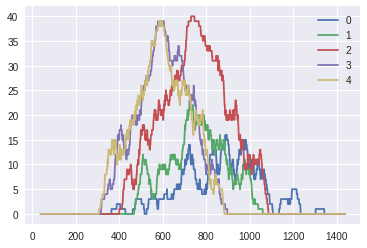

In [130]:
np.random.shuffle(fake_data)
all_data = pd.DataFrame(fake_data)
all_data.head(5).T.rolling(40).sum().plot()


# Build Seq2Seq Model

## hyperparameters

In [0]:

batch_size = 17   # Batch size for training. 85/5 = 17
epochs = 100  # Number of epochs to train for.
latent_dim = 4  # Latent dimensionality of the encoding space.
num_samples = all_data.shape[0]  # Number of samples to train on.

# data spliting

we have `85` data vectors, each data vector is a time series with the length of `1440`, each time point has `1` feature.

suppose we have 17 batches

In [132]:


decoder_data = all_data.copy()
decoder_data[0] = 255
display(decoder_data.head(5))

print('decoder_data', decoder_data.shape)


,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


decoder_data (85, 1440)


In [133]:
decoder_output_data = all_data.copy().shift(-1, axis=1)
decoder_output_data.iloc[:,-1]=0
decoder_output_data = decoder_output_data.astype(int)

det = decoder_output_data.T[10][1:] - decoder_data.T[10][1:]
det.clip(0,1).sum()

10

## build the model

Encoder:
1. Input
2. LSTM -> take out the hidden value


In [134]:
r_encoder_data = all_data.as_matrix()[:,:,None]
print(r_encoder_data.shape)

r_decoder_data = decoder_data.as_matrix()[:,:,None]
print(r_decoder_data.shape)

r_decoder_output_data = decoder_output_data.as_matrix()[:,:,None]
print(r_decoder_output_data.shape)

(85, 1440, 1)
(85, 1440, 1)
(85, 1440, 1)


In [135]:
max_time_pace = 30
sample_size = int(day_length*(num_of_each_type*4 + num_of_weekend )/max_time_pace)

r_encoder_data = r_encoder_data.reshape(sample_size, max_time_pace, 1)           
r_decoder_data = r_decoder_data.reshape(sample_size, max_time_pace, 1)    
r_decoder_output_data = r_decoder_output_data.reshape(sample_size, max_time_pace, 1)    

print(r_encoder_data.shape)
print(r_decoder_data.shape)
print(r_decoder_output_data.shape)

(4080, 30, 1)
(4080, 30, 1)
(4080, 30, 1)


In [0]:
from keras.optimizers import Adam

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, 1))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, 1))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(1, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer=Adam(), loss='binary_crossentropy')
train_history = model.fit([r_encoder_data, r_decoder_data], r_decoder_output_data,
          batch_size=batch_size,
#           epochs=3,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')


Train on 3264 samples, validate on 816 samples
Epoch 1/100
3264/3264 [==============================] - 30s 9ms/step - loss: 0.5206 - val_loss: 0.3801
Epoch 2/100
3264/3264 [==============================] - 29s 9ms/step - loss: 0.2994 - val_loss: 0.2674
Epoch 3/100
1581/3264 [=============>................] - ETA: 13s - loss: 0.2529

3264/3264 [==============================] - 29s 9ms/step - loss: 0.2521 - val_loss: 0.2465
Epoch 4/100
3264/3264 [==============================] - 29s 9ms/step - loss: 0.2394 - val_loss: 0.2372
Epoch 5/100
3264/3264 [==============================] - 29s 9ms/step - loss: 0.2274 - val_loss: 0.2243
Epoch 6/100
 323/3264 [=>............................] - ETA: 24s - loss: 0.2244

3264/3264 [==============================] - 29s 9ms/step - loss: 0.2161 - val_loss: 0.2143
Epoch 7/100
3264/3264 [==============================] - 29s 9ms/step - loss: 0.2105 - val_loss: 0.2096
Epoch 8/100
3264/3264 [==============================] - 29s 9ms/step - loss: 0.2070 - val_loss: 0.2068
Epoch 9/100
 102/3264 [..............................] - ETA: 27s - loss: 0.2271

3264/3264 [==============================] - 29s 9ms/step - loss: 0.2045 - val_loss: 0.2045
Epoch 10/100
3264/3264 [==============================] - 29s 9ms/step - loss: 0.2026 - val_loss: 0.2015
Epoch 11/100
3264/3264 [==============================] - 29s 9ms/step - loss: 0.2005 - val_loss: 0.1995
Epoch 12/100
  34/3264 [..............................] - ETA: 27s - loss: 0.2499

3264/3264 [==============================] - 29s 9ms/step - loss: 0.1988 - val_loss: 0.1975
Epoch 13/100
3264/3264 [==============================] - 29s 9ms/step - loss: 0.1971 - val_loss: 0.1966
Epoch 14/100
 595/3264 [====>.........................] - ETA: 22s - loss: 0.1921

In [35]:
!ls


datalab  s2s.h5


In [0]:
from google.colab import files
files.download('s2s.h5')

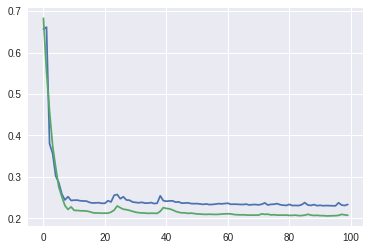

In [41]:
plt.plot(train_history.history['val_loss'])
plt.plot(train_history.history['loss'])

<tf.Tensor 'lstm_4_1/while/Exit_3:0' shape=(?, 256) dtype=float32>

## Inference

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

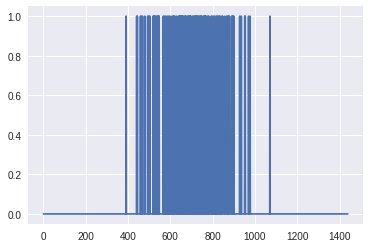

In [52]:
test_seq = generate_binary(gaussian_pdf(0,1,day_length))
plt.plot(test_seq)


(1, 60, 1)

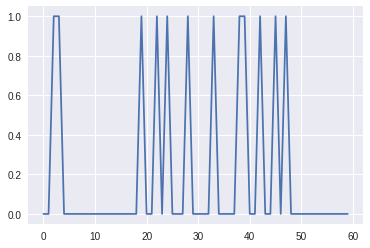

In [57]:
part_test = test_seq[500:560]
plt.plot(part_test)
part_test = part_test.reshape([1, part_test.shape[0],1])
part_test.shape

In [0]:
state_value = encoder_model.predict(part_test)
# state_value

In [86]:
start_seq = np.zeros([1,1,1])
start_seq[0,0,0] = 255

state_value[0].shape

(1, 256)

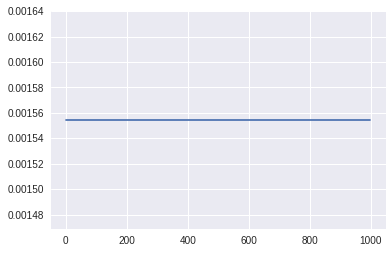

In [85]:
generate_size = 1000

generated = []
for i in range(generate_size):
  decoder_model_input = [start_seq]+state_value
  output_, h, c = decoder_model.predict(decoder_model_input)
  generated.append(output_)
  state_value = [h,c]
  start_seq[0,0,0] = output_

  
generated = np.array(generated).reshape([generate_size])
plt.plot(generated)

Hmmmmm, this model cannot learn any thing. Frustrated, but let me finish the clustering

## Clustering based on the result

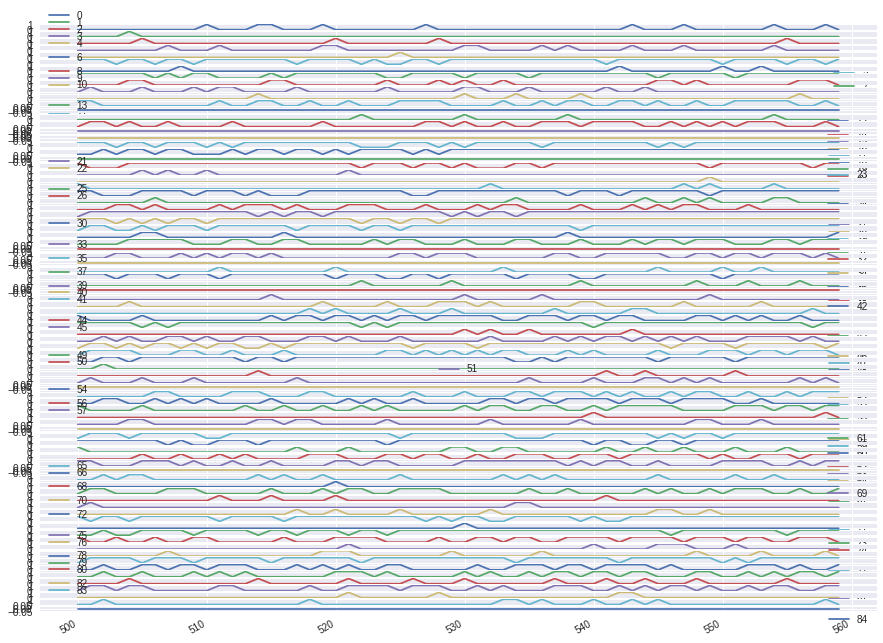

In [98]:
all_data.shape


sampled_data = all_data.iloc[:,500:560]
sampled_data.T.plot(subplots=True, figsize=(15,12))
plt.show()

In [101]:
r_sampled_data = sampled_data.as_matrix().reshape(85,60,1)
r_sampled_data[0].shape

(60, 1)

Keras provides the return_state argument to the LSTM layer that will provide access to the hidden state output (state_h) and the cell state (state_c).

In [105]:
state_value_set = [encoder_model.predict(each.reshape(1,60,1)) for each in r_sampled_data]

# state_value = encoder_model.predict(sampled_data)
len(state_value_set)

85

In [112]:
state_value_set[0][0].shape

(1, 256)

In [116]:
train_set = [np.concatenate([each[0],each[1]]) for each in state_value_set] 
train_set = np.array(train_set).reshape(85,-1)
train_set.shape

(85, 512)

In [0]:
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster




# Test Ground


In [189]:
test_d = all_data.as_matrix().reshape(-1)

test_d.shape

(122400,)

In [204]:
trainX = test_d.copy()
trainY = test_d[30:]
trainY = np.concatenate([trainY, np.zeros(30).astype('int')])
trainY.shape

(122400,)

In [236]:
trainX = trainX.reshape(-1, 30, 1)
trainY = trainY.reshape(-1, 30, 1)

trainY.shape

(4080, 30, 1)

In [233]:
trainY = trainY.reshape(-1,30)
trainY.shape

(4080, 30)

In [42]:
model = Sequential()
model.add(LSTM(4,return_sequences=True, input_shape=(None, 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=1)




NameError: ignored